Basic NLP Classification Model Detecting Fake/Real News Using Naive Bayes and Sentiment Analysis

First, take the data from the PostgreSQL Database and extract the data into a df

In [53]:
# Used for importing the Postgresql DB 
import rds_config_stuff # type: ignore
from sqlalchemy import create_engine  # type: ignore 
import pandas as pd

# Engine creates the connection between the hosted db 
engine = create_engine(f'postgresql://{rds_config_stuff.db_user}:{rds_config_stuff.db_pass}@{rds_config_stuff.db_host}:{5432}/{rds_config_stuff.db_name}')

# Create a df and select the necessary columns 
df = pd.read_sql("SELECT title, text, subject, label FROM articles_real_fake", engine)

pd.set_option('display.max_colwidth', None)

df.head()

,title,text,subject,label
0,Donald Trump Sends Out Embarrassing New Yearâs Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,fake
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the forme

Clean the mojibake found within the titles and articles

In [54]:
# Cleaning the titles of special characters, demonstrates importance of cleaning data and prepping it for use by models
# Simpler way to standardize the data: fake_df['title'] = fake_df['title'].str.replace(r'[^\w\s]', '', regex=True)

def clean_text(text):
    str(text)
    try:
        # Used to attempt to remove the mojibake from the sheet
        text = text.encode("latin1").decode("utf-8")
    except:
        pass

    return text

df['title'] = df['title'].apply(clean_text)
df['text'] = df['text'].apply(clean_text)

df.head()

,title,text,subject,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,fake
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former 

Supervised Training: When ML training datasets are labelled

In [55]:
# Supplemental sklearn imports 
from sklearn.model_selection import train_test_split

# Used for the model to determine Real/Fake 
from sklearn.pipeline import Pipeline # type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Split the data into attributes and the label to begin supervised training

X = df[['title', 'text', 'subject']]
y = df['label']

# Splitting the data into training and testing 
# stratify mantains an equal ratio between "TRUE" and "FALSE" labels for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Creating a pipeline, step by step process
# Turn the data into vectors with TFIDF -> Apply Naive Bayes 
model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),('clf', MultinomialNB())])

Below is the Naive Bayes Formula:

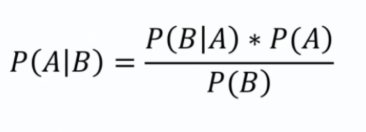

First Test: Title + Text + Subject

In [56]:
from sklearn.metrics import accuracy_score

# There are different approaches that can be used, whether it be soley using either 
# an individual column to evaluate if the model can detect the difference or not.
# Lets start with all the factors combined...

X_train_full = X_train['title'] + ' ' + X_train['text'] + ' ' + X_train['subject']
X_test_full = X_test['title'] + ' ' + X_test['text'] + ' ' + X_test['subject']

# This is then used to fit the data into the pipeline 
model.fit(X_train_full, y_train)

y_pred = model.predict(X_test_full)

# Determines the accuracy of the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9428730512249444


Second Test: Just Title

In [57]:
# First, lets simply try using the titles to determine the accuracy from there 

model.fit(X_train['title'], y_train)

y_pred = model.predict(X_test['title'])

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9312917594654788


Third Test: Just Base Text

In [58]:
# Now, lets check the text within the articles to see if there is any improvement...

model.fit(X_train['text'], y_train)

y_pred = model.predict(X_test['text'])

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9361915367483297


Next, Sentiment Analysis will be applied to the data using VADER

In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon 
nltk.download('vader_lexicon')

# Here, you can use a custom Vader Lexicon but thats not necessary 
sia = SentimentIntensityAnalyzer()

# Sentiment analysis, closer to -1 neg, closer to 1 pos
df['sentiment'] = df['title'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

df.head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jgarc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,title,text,subject,label,sentiment
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,fake,-0.7096
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known befor

Finding the average sentiment in the dataset

In [60]:
print(df.groupby('label')['sentiment'].mean())

label
fake   -0.160659
real   -0.067406
Name: sentiment, dtype: float64


Finally, this is an attempt to weave Generative AI into this project using Markov Chains 

In [64]:
import markovify # type: ignore 

real_titles = df[df['label'] == 'real']['title']
fake_titles = df[df['label'] == 'fake']['title']

real_list = " ".join(real_titles.tolist())
fake_list = " ".join(fake_titles.tolist())

real_model = markovify.Text(real_list)
fake_model = markovify.Text(fake_list)

print("Generated real news title: ", real_model.make_sentence(tries=100))
print("Generated false news title: ", fake_model.make_sentence(tries=100))

Generated real news title:  Britain's Johnson says no need for gloom about Trump victory Trump win puts U.S.-Russia hostility on hold - but for how long?
Generated false news title:  NEW EVIDENCE SHOWS WOMAN Who Accused Trump Of Sexual Assault Allegations Against Bill Clinton And Trump In 2020?


In [ ]:
# Used for the UI 
import ipywidgets as widgets # type: ignore 
from IPython.display import display

# Widgets to input data 
title_input = widgets.Textarea(
    value='', placeholder='Enter article title here', 
    description='Title', layout=widgets.Layout(width='100%', height='80px')
    )

text_input = widgets.Textarea(
    value='', placeholder='Enter article title here', 
    description='Text', layout=widgets.Layout(width='100%', height='80px')
    )

subject_input = widgets.Textarea(
    value='', placeholder='Enter subject here', 
    description='Subject', layout=widgets.Layout(width='100%', height='80px')
    )

output = widgets.Output()

# Logic of the model to interpret the user data
def submit(b):
    full_prompt = title_input.value + ' ' + text_input.value + ' ' + subject_input.value

    input_df = pd.Series([full_prompt])

    pred_indiv = model.predict(input_df)[0]

    sentiment_score = sia.polarity_scores(full_prompt)['compound']
    
    with output:
        output.clear_output()
        print("Predicition: ", pred_indiv)
        print("Sentiment Score: ", sentiment_score)

# Submit Button
submit_button = widgets.Button(description="Run Predicition", button_style='success')
submit_button.on_click(submit)

display(title_input, text_input, subject_input, submit_button, output)

Textarea(value='', description='Title', layout=Layout(height='80px', width='100%'), placeholder='Enter article…

Textarea(value='', description='Text', layout=Layout(height='80px', width='100%'), placeholder='Enter article …

Textarea(value='', description='Subject', layout=Layout(height='80px', width='100%'), placeholder='Enter subje…

Button(button_style='success', description='Run Predicition', style=ButtonStyle())

Output()